In [3]:
!pip install rasterio einops -q

In [4]:
import zipfile
import os
import argparse
import numpy as np
import pandas as pd
import random
import einops
import time
import itertools
from pathlib import Path
import rasterio
from tqdm import tqdm
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from PIL import Image, ImageDraw, ImageFont
import random
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix ,classification_report, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve
import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision.datasets import EuroSAT
from torchvision.utils import save_image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader
from transformers import ViTModel, ViTConfig, ViTForImageClassification
from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.utils import save_image, make_grid
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
# Define the root directory where you want the dataset to be downloaded
root_dir = Path('/content/')
zip_path = '/content/eurosat/EuroSAT.zip'


# Download and setup the EuroSAT dataset
eurosat_dataset = EuroSAT(root=root_dir, download=True, transform=transforms.ToTensor())
os.remove(zip_path)

100%|██████████| 94280567/94280567 [00:07<00:00, 12986489.53it/s]


Extracting /content/eurosat/EuroSAT.zip to /content/eurosat


In [ ]:
def count_files_in_subdirectories(directory):
    if not os.path.exists(directory):
        print(f"The directory {directory} does not exist.")
        return

    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print("Number of files:", len(files))
directory_path = '/content/eurosat'
count_files_in_subdirectories(directory_path)

Directory: /content/eurosat
Number of files: 0
Directory: /content/eurosat/2750
Number of files: 0
Directory: /content/eurosat/2750/AnnualCrop
Number of files: 3000
Directory: /content/eurosat/2750/HerbaceousVegetation
Number of files: 3000
Directory: /content/eurosat/2750/Forest
Number of files: 3000
Directory: /content/eurosat/2750/Pasture
Number of files: 2000
Directory: /content/eurosat/2750/Industrial
Number of files: 2500
Directory: /content/eurosat/2750/SeaLake
Number of files: 3000
Directory: /content/eurosat/2750/PermanentCrop
Number of files: 2500
Directory: /content/eurosat/2750/Residential
Number of files: 3000
Directory: /content/eurosat/2750/River
Number of files: 2500
Directory: /content/eurosat/2750/Highway
Number of files: 2500


In [ ]:
# set the path to the directory containing the EuroSAT dataset
data_dir = '/content/eurosat/2750'
new_directory_path = '/content/EuroSat_np'
os.makedirs(new_directory_path, exist_ok=True)
gen_dir_path = '/content/eurosat/2750/generated'
os.makedirs(gen_dir_path, exist_ok=True)
# set the path to the directory where the npy files will be saved
output_dir = '/content/EuroSat_np'

# define a list of the class names in the dataset
class_names = ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial',
               'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']

# loop over each class
for i in range(len(class_names)):
    # get the name of the current class
    class_name = class_names[i]

    # set the path to the directory containing the
    #  images for the current class
    class_dir = os.path.join(data_dir, class_name)

    # get a list of the filenames of the images for the current class
    image_filenames = os.listdir(class_dir)

    # initialize an empty array to hold the image data
    X = np.zeros((len(image_filenames), 64, 64, 3))

    # loop over each image in the current class
    for j in range(len(image_filenames)):
        # get the filename of the current image
        image_filename = image_filenames[j]

        # set the path to the current image
        image_path = os.path.join(class_dir, image_filename)

        #print(image_path)


        # open the image using rasterio
        with rasterio.open(image_path) as src:
            # read the image data as a numpy array
            image = src.read()

        # transpose the image data to the shape (3, 64, 64)
        image = np.transpose(image, (1, 2, 0))
        #np.float32(img)


        # add the image data to the X array
        X[j,:,:,:] = image

    # save the X array as an npy file
    np.save(os.path.join(output_dir, f'X{i}.npy'), X)

    # create an array of labels for the current class
    y = np.ones(len(image_filenames)) * i

    # save the y array as an npy file
    np.save(os.path.join(output_dir, f'y{i}.npy'), y)

/usr/local/lib/python3.10/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


RasterioIOError: '/content/eurosat/2750/AnnualCrop/non_watermarked' not recognized as a supported file format.

In [ ]:
# set the path to the directory containing the npy files
data_dir = '/content/EuroSat_np'

# set the path to save the trained model
model_path = '/content/eurosat'

In [ ]:
# Load data
X, y = [], []
for i in range(10):  # X0.npy through X9.npy and corresponding y files.
    X_i = np.load(f'{data_dir}/X{i}.npy')
    y_i = np.load(f'{data_dir}/y{i}.npy')

    # Debug: Print the shape of each loaded part
    print(f'X{i}.npy shape: {X_i.shape}')

    X.append(X_i)
    y.append(y_i)

# Concatenate all parts into a single array
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)

# Final check on the full dataset
print("Total images loaded: ", X.shape)
print("Total labels loaded: ", y.shape)

X0.npy shape: (3000, 64, 64, 3)
X1.npy shape: (3000, 64, 64, 3)
X2.npy shape: (3000, 64, 64, 3)
X3.npy shape: (2500, 64, 64, 3)
X4.npy shape: (2500, 64, 64, 3)
X5.npy shape: (2000, 64, 64, 3)
X6.npy shape: (2500, 64, 64, 3)
X7.npy shape: (3000, 64, 64, 3)
X8.npy shape: (2500, 64, 64, 3)
X9.npy shape: (3000, 64, 64, 3)
Total images loaded:  (27000, 64, 64, 3)
Total labels loaded:  (27000,)


In [ ]:
DATASET = "/content/eurosat/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['AnnualCrop', 'HerbaceousVegetation', 'Forest', 'Pasture', 'Industrial', 'SeaLake', 'PermanentCrop', 'Residential', 'River', 'Highway']


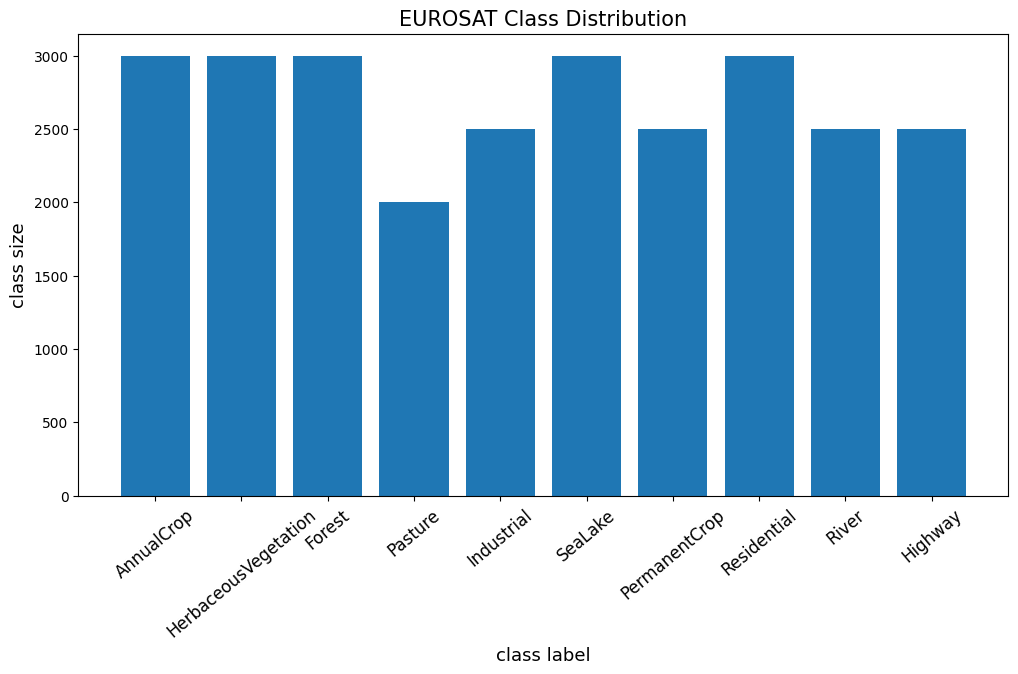

In [ ]:
# plot class distributions of whole dataset
counts = {}

for l in LABELS:
    counts[l] = len(os.listdir(os.path.join(DATASET, l)))


plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

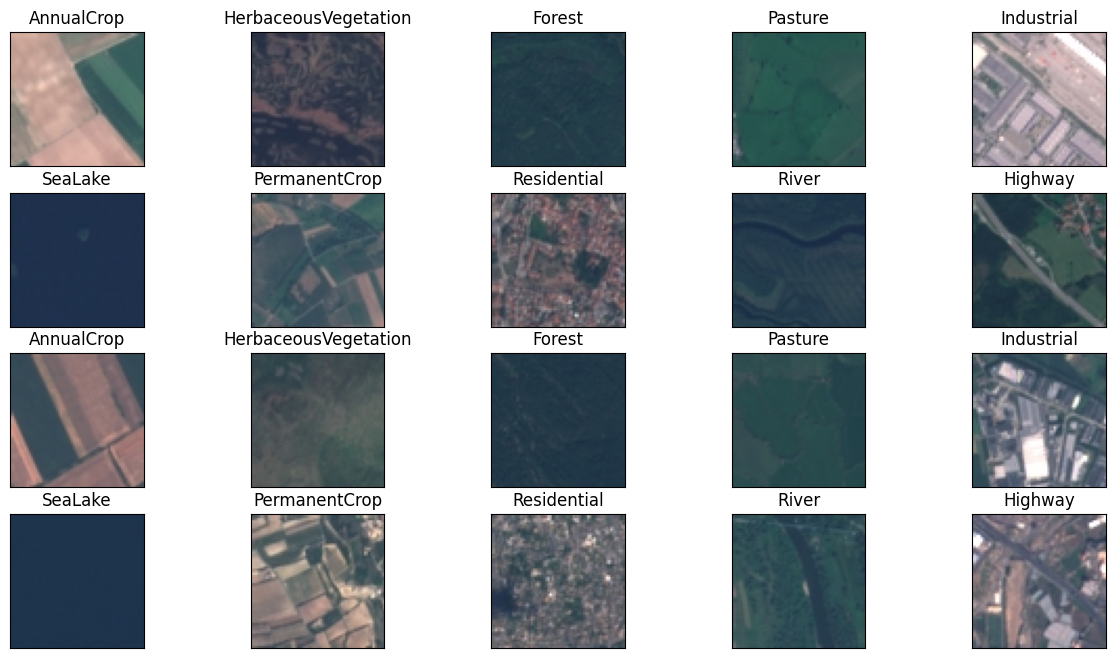

In [ ]:
img_paths = [os.path.join(DATASET, l, l+'_1000.jpg') for l in LABELS]

img_paths = img_paths + [os.path.join(DATASET, l, l+'_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    plt.figure(figsize=(15, 8))
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

In [ ]:
print(X.shape)

#X = rearrange(X, 'b h w c -> b c h w')

#print(X.shape)

(27000, 64, 64, 3)


In [ ]:
# split the data into training and testing sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# split the data
for train_idx, test_idx in split.split(X, y):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

In [ ]:
def apply_watermark(image_array, text='H', font_size=8, opacity=20):
    # Convert the numpy array to a PIL Image
    image = Image.fromarray(image_array.astype('uint8'), 'RGB')

    # Define the font
    font = ImageFont.load_default()

    # Create a drawing context to measure text
    dummy_image = Image.new("RGB", (1, 1))
    dummy_draw = ImageDraw.Draw(dummy_image)

    # Get the bounding box of the text
    text_width, text_height = dummy_draw.textbbox((0, 0), text, font=font)[2:]

    # Convert image to RGBA to add opacity
    image = image.convert("RGBA")
    overlay = Image.new("RGBA", image.size)
    draw = ImageDraw.Draw(overlay)

    # Randomize position within the boundaries of the image
    max_x = image.size[0] - text_width  # Width of image minus width of text
    max_y = image.size[1] - text_height  # Height of image minus height of text
    random_position = (random.randint(0, max_x), random.randint(0, max_y))

    # Text color with opacity
    text_color = (255, 255, 255, opacity)  # Adjust the opacity here

    # Place the text on the overlay image with partial opacity
    draw.text(random_position, text, font=font, fill=text_color)

    # Combine the overlay with the image
    watermarked_image = Image.alpha_composite(image, overlay)

    # Convert back to RGB to drop the alpha channel
    watermarked_image = watermarked_image.convert("RGB")

    # Convert back to numpy array
    return np.array(watermarked_image)

In [ ]:
class EuroSATDataset(Dataset):
    def __init__(self, X, y, watermark_prob=0.5):
        self.X = X
        self.y = y
        self.watermark_prob = watermark_prob
        self.watermarks = np.random.rand(len(X)) < watermark_prob

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = self.X[idx]
        landscape_label = self.y[idx]
        watermark_label = self.watermarks[idx]

        # Apply watermark if flagged
        if watermark_label:
            image = apply_watermark(image)

        # Convert the image to a tensor and rearrange to 'channels first'
        image = torch.from_numpy(image).float()
        image = image.permute(2, 0, 1)  # Ensuring channels first format

        landscape_label = torch.tensor(landscape_label, dtype=torch.long)
        return image, landscape_label, watermark_label

    def save_dataset_images(dataset, root_dir):
    # Iterate over the dataset with a progress bar
      for i in tqdm(range(len(dataset)), desc="Saving images"):
        image, landscape_label, watermark_label = dataset[i]
        label_name = labels[landscape_label]  # Assuming landscape_label is the index in the labels list

        # Determine the subfolder based on the watermark label
        subfolder = "watermarked" if watermark_label else "non_watermarked"
        file_path = os.path.join(root_dir, label_name, subfolder, f"{i}.png")

        # Save the image
        save_image(image, file_path)

# Create the DataLoader for both training and testing datasets
train_dataset = EuroSATDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = EuroSATDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
# set the device to use for training and testing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(len(train_loader))

675


In [ ]:
print(len(test_loader))

169


In [ ]:
root_dir = "/content/eurosat/2750/"
labels = ['Forest', 'HerbaceousVegetation', 'AnnualCrop', 'Industrial', 'PermanentCrop', 'SeaLake', 'Residential', 'River', 'Pasture', 'Highway']

# Create a directory for each label and subdirectories for watermarked and non-watermarked
for label in labels:
    os.makedirs(os.path.join(root_dir, label, "watermarked"), exist_ok=True)
    os.makedirs(os.path.join(root_dir, label, "non_watermarked"), exist_ok=True)


# Vit blocks

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768, img_size: int = 224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.cls_token = nn.Parameter(torch.randn(1,1, emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))


    def forward(self, x: Tensor) -> Tensor:
        b, _, _, _ = x.shape
        x = self.projection(x)
        cls_tokens = repeat(self.cls_token, '() n e -> b n e', b=b)
        # prepend the cls token to the input
        x = torch.cat([cls_tokens, x], dim=1)
        # add position embedding
        x += self.positions
        return x

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        # fuse the queries, keys and values in one matrix
        self.qkv = nn.Linear(emb_size, emb_size * 3)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)

    def forward(self, x : Tensor, mask: Tensor = None) -> Tensor:
        # split keys, queries and values in num_heads
        qkv = rearrange(self.qkv(x), "b n (h d qkv) -> (qkv) b h n d", h=self.num_heads, qkv=3)
        queries, keys, values = qkv[0], qkv[1], qkv[2]
        # sum up over the last axis
        energy = torch.einsum('bhqd, bhkd -> bhqk', queries, keys) # batch, num_heads, query_len, key_len
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)

        scaling = self.emb_size ** (1/2)
        att = F.softmax(energy, dim=-1) / scaling
        att = self.att_drop(att)
        # sum up over the third axis
        out = torch.einsum('bhal, bhlv -> bhav ', att, values)
        out = rearrange(out, "b h n d -> b n (h d)")
        out = self.projection(out)
        return out

In [ ]:
class ResidualAdd(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        res = x
        x = self.fn(x, **kwargs)
        x += res
        return x

In [ ]:
class FeedForwardBlock(nn.Sequential):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super().__init__(
            nn.Linear(emb_size, expansion * emb_size),
            nn.GELU(),
            nn.Dropout(drop_p),
            nn.Linear(expansion * emb_size, emb_size),
        )

In [ ]:
class TransformerEncoderBlock(nn.Sequential):
    def __init__(self,
                 emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 ** kwargs):
        super().__init__(
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                MultiHeadAttention(emb_size, **kwargs),
                nn.Dropout(drop_p)
            )),
            ResidualAdd(nn.Sequential(
                nn.LayerNorm(emb_size),
                FeedForwardBlock(
                    emb_size, expansion=forward_expansion, drop_p=forward_drop_p),
                nn.Dropout(drop_p)
            )
            ))

In [ ]:
class TransformerEncoder(nn.Sequential):
    def __init__(self, depth: int = 12, **kwargs):
        super().__init__(*[TransformerEncoderBlock(**kwargs) for _ in range(depth)])


In [ ]:
class ClassificationHead(nn.Sequential):
    def __init__(self, emb_size: int = 768, n_classes: int = 1000):
        super().__init__(
            Reduce('b n e -> b e', reduction='mean'),
            nn.LayerNorm(emb_size),
            nn.Linear(emb_size, n_classes))

In [ ]:
class ViT(nn.Sequential):
    def __init__(self,
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 64,
                depth: int = 12,
                n_classes: int = 10,
                **kwargs):
        super().__init__(
            PatchEmbedding(in_channels, patch_size, emb_size, img_size),
            TransformerEncoder(depth, emb_size=emb_size, **kwargs),
            ClassificationHead(emb_size, n_classes)
        )

In [ ]:
summary(ViT().cuda(), (3, 64, 64), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 768, 4, 4]         590,592
         Rearrange-2              [-1, 16, 768]               0
    PatchEmbedding-3              [-1, 17, 768]               0
         LayerNorm-4              [-1, 17, 768]           1,536
            Linear-5             [-1, 17, 2304]       1,771,776
           Dropout-6            [-1, 8, 17, 17]               0
            Linear-7              [-1, 17, 768]         590,592
MultiHeadAttention-8              [-1, 17, 768]               0
           Dropout-9              [-1, 17, 768]               0
      ResidualAdd-10              [-1, 17, 768]               0
        LayerNorm-11              [-1, 17, 768]           1,536
           Linear-12             [-1, 17, 3072]       2,362,368
             GELU-13             [-1, 17, 3072]               0
          Dropout-14             [-1, 1

In [ ]:
model = ViT()
model=model.cuda()

In [ ]:
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 10


In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
train_losses = []
train_accu = []

def train(epoch):
    print('Epoch : %d'%epoch)

    model.train()
    running_loss=0
    correct=0
    total=0
    for images, landscape_labels, _ in tqdm(train_loader):
        images = images.float().cuda()
        landscape_labels = landscape_labels.float().cuda()
        #print(images.size())
        #print(labels.size())
        # Forward pass
        #model = model.cuda()
        outputs = model(images)
        labels1= np.zeros((32,10))

        #labels1 = tensor.detach().cpu().numpy()
        for j in range(32):
            i=landscape_labels[j]
            i=int(i.item())
            # print(i)
            labels1[j][i]=1
        labels1=torch.from_numpy(labels1)
        #print(labels1.size())
        labels1=labels1.to(device='cuda')
        loss = criterion(outputs, labels1)


       # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    #Replaces pow(2.0) with abs() for L1 regularization

#     l2_lambda = 0.001
#     l2_norm = sum(p.pow(2.0).sum()
#                   for p in model.parameters())

#     loss = loss + l2_lambda * l2_norm


        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += landscape_labels.size(0)
        correct += predicted.eq(landscape_labels).sum().item()

    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total

    train_accu.append(accu)
    train_losses.append(train_loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))


In [ ]:
eval_losses=[]
eval_accu=[]

def test(epoch):
    model.eval()

    running_loss=0
    correct=0
    total=0
    #print(test_loader)
    with torch.no_grad():
        for images, landscape_labels, _ in tqdm(train_loader):
            #images = images.to(device='cuda', dtype=torch.float)
            images = images.float().cuda()
            landscape_labels = landscape_labels.float().cuda()
            #labels = labels.to(device='cuda', dtype=torch.float)

            # Predict classes using the model
            outputs = model(images)
            #print(labels.size())
            t,y=outputs.shape
            # print(t)
            labels1= np.zeros((t,10))
            for j in range(t):
                i=landscape_labels[j]
                i=int(i.item())
                labels1[j][i]=1
            labels1=torch.from_numpy(labels1)
            #print(labels1.size())
            labels1=labels1.to(device='cuda')
            #outputs=outputs.tensor()
            loss= criterion(outputs,labels1)
            running_loss+=loss.item()


           # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += landscape_labels.size(0)
            correct += (predicted == landscape_labels).sum().item()

    test_loss=running_loss/len(test_loader)
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu))


In [ ]:
epochs = 100

# Start the time

start_time = time.time()
for epoch in range(1,epochs+1):
    train(epoch)
    # Save the model after training
    test(epoch)
    # Save the model after testing
# End the timer
end_time = time.time()

# Calculate the training time
training_time = end_time - start_time

print('Training time: {:.2f} seconds'.format(training_time))

Epoch : 1


100%|██████████| 675/675 [00:29<00:00, 23.09it/s]


Train Loss: 1.149 | Accuracy: 59.093


100%|██████████| 675/675 [00:12<00:00, 55.42it/s]


Test Loss: 4.256 | Accuracy: 61.537
Epoch : 2


100%|██████████| 675/675 [00:29<00:00, 23.11it/s]


Train Loss: 1.065 | Accuracy: 61.361


100%|██████████| 675/675 [00:12<00:00, 55.30it/s]


Test Loss: 3.812 | Accuracy: 65.278
Epoch : 3


100%|██████████| 675/675 [00:29<00:00, 23.05it/s]


Train Loss: 0.969 | Accuracy: 64.972


100%|██████████| 675/675 [00:12<00:00, 54.81it/s]


Test Loss: 4.036 | Accuracy: 63.144
Epoch : 4


100%|██████████| 675/675 [00:29<00:00, 23.08it/s]


Train Loss: 1.221 | Accuracy: 57.014


100%|██████████| 675/675 [00:12<00:00, 54.93it/s]


Test Loss: 4.098 | Accuracy: 62.981
Epoch : 5


100%|██████████| 675/675 [00:29<00:00, 23.11it/s]


Train Loss: 1.207 | Accuracy: 57.148


100%|██████████| 675/675 [00:12<00:00, 55.45it/s]

Test Loss: 4.085 | Accuracy: 62.306
Training time: 207.40 seconds


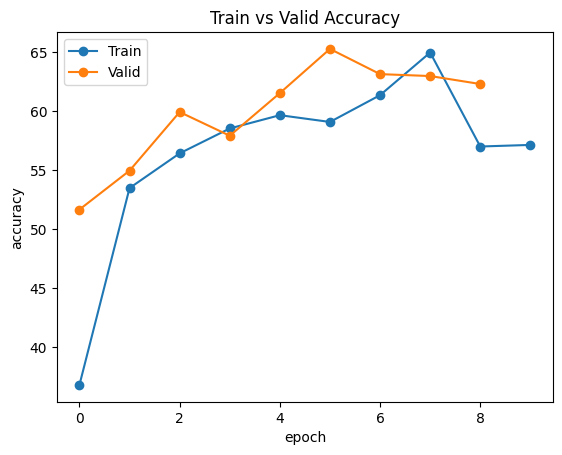

In [ ]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

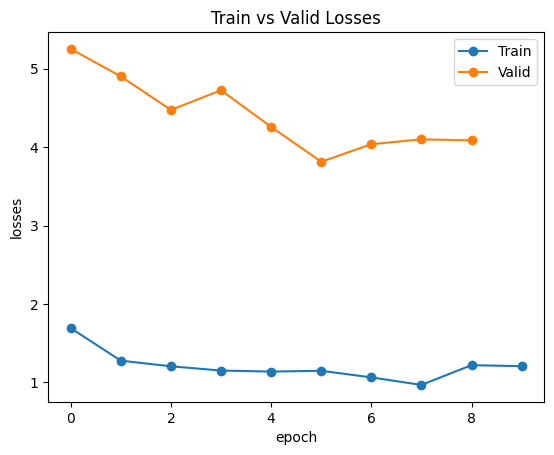

In [ ]:
#plot losses

plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [ ]:
# testing
ttloss = []
ttacc = []
ttf1 = []

T_val = []
P_val = []

with torch.no_grad():
    model.eval()
    for X_val, y_val, _ in tqdm(test_loader):
        X_val = X_val.float().cuda()
        X_val, y_val = X_val.to(device), y_val.to(device)
        #y_val = y_val.type(torch.cuda.LongTensor)

        output = model(X_val)
        #print(output.shape)

        outputs = torch.max(output, dim=1)[1]
        #print(outputs.shape)
        T_val.extend(y_val.cpu().numpy())
        #print(T_val)
        P_val.extend(outputs.cpu().numpy())
    #print(T_val)
    #print(P_val)
    precision = precision_score(T_val, P_val, average='macro')
    recall = recall_score(T_val, P_val, average='macro')
    res = confusion_matrix(T_val, P_val)
    report = classification_report(T_val, P_val)

    print("Precision: ",precision)
    print("Recall: ",recall)

    print('Confusion matrix:\n',res)
    print('Report:\n',report)


# with torch.no_grad():
#     model.eval()
#     for id, (X_val, y_val) in enumerate(val_data):
#         X_val, y_val = X_val.to(device), y_val.to(device)
#         y_val = y_val.type(torch.cuda.LongTensor)

#         output = model(X_val)
#         outputs = torch.max(output, dim=1)[1]
#         T_val.extend(y_val.cpu().numpy())
#         P_val.extend(outputs.cpu().numpy())
#     print(T_val)
#     print(P_val)
#     precision = precision_score(T_val, P_val, average='macro')
#     recall = recall_score(T_val, P_val, average='macro')
#     res = confusion_matrix(T_val, P_val)
#     report = classification_report(T_val, P_val)

#     print("Precision: ",precision)
#     print("Recall: ",recall)

#     print('Confusion matrix:\n',res)
#     print('Report:\n',report)

100%|██████████| 169/169 [00:02<00:00, 57.99it/s]


Precision:  0.632189421119721
Recall:  0.6187833333333334
Confusion matrix:
 [[506   3   4  13  11   7  12  32   6   6]
 [  0 531   9   4   0  26   0   6   8  16]
 [ 67   1 258  28  29   9  65 136   5   2]
 [127   1   9 147  66  21   5  79  45   0]
 [  6   0   0   4 476   0   0  12   2   0]
 [ 15  17  20   5   2 295  14  20   8   4]
 [247   0  38  31  23   8  98  54   1   0]
 [ 22   0  18  22  56   3  16 462   1   0]
 [ 60  18  13 135  32  34   0  19 180   9]
 [  4  93   7   1   0  10   0  32  21 432]]
Report:
               precision    recall  f1-score   support

           0       0.48      0.84      0.61       600
           1       0.80      0.89      0.84       600
           2       0.69      0.43      0.53       600
           3       0.38      0.29      0.33       500
           4       0.68      0.95      0.80       500
           5       0.71      0.74      0.73       400
           6       0.47      0.20      0.28       500
           7       0.54      0.77      0.64       

#Watermark Detection CNN

In [ ]:
class WatermarkDetectorCNN(nn.Module):
    def __init__(self):
        super(WatermarkDetectorCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # The feature map size depends on your input image size. Assuming an input size of (3, 64, 64),
        # the output size here would be (128, 8, 8) after three rounds of max pooling (2, 2) starting from 64x64.
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),  # 128 channels, each 8x8 from the last pooling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 2) # Output layer for binary classification
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.flatten(x, start_dim=1)  # Flatten all dimensions except batch
        x = self.fc_layers(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = WatermarkDetectorCNN().to(device)
# Initialize the CrossEntropyLoss function
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


# Training loop
model.train()  # Set the model to training mode
num_epochs = 100
epoch_losses = []
all_labels = []
all_scores = []


for epoch in range(num_epochs):
    batch_losses = []
    for images, _, watermark_labels in tqdm(train_loader):  # Adjusted to ignore landscape labels
        images = images.to(device)
        watermark_labels = watermark_labels.to(device)  # Ensure labels are long integers
        watermark_labels = watermark_labels.long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, watermark_labels)  # Labels are class indices
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()

        batch_losses.append(loss.item())

    # Calculate and store the average loss for this epoch
    epoch_losses = np.mean(batch_losses)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_losses:.4f}')

100%|██████████| 675/675 [00:07<00:00, 84.79it/s]


Epoch [1/10], Loss: 0.6944


100%|██████████| 675/675 [00:07<00:00, 91.44it/s]


Epoch [2/10], Loss: 0.6931


100%|██████████| 675/675 [00:07<00:00, 90.83it/s]


Epoch [3/10], Loss: 0.6924


100%|██████████| 675/675 [00:07<00:00, 90.65it/s]


Epoch [4/10], Loss: 0.6909


100%|██████████| 675/675 [00:07<00:00, 90.49it/s]


Epoch [5/10], Loss: 0.6869


100%|██████████| 675/675 [00:07<00:00, 90.11it/s]


Epoch [6/10], Loss: 0.6784


100%|██████████| 675/675 [00:07<00:00, 90.57it/s]


Epoch [7/10], Loss: 0.6603


100%|██████████| 675/675 [00:07<00:00, 91.32it/s]


Epoch [8/10], Loss: 0.6365


100%|██████████| 675/675 [00:07<00:00, 90.73it/s]


Epoch [9/10], Loss: 0.6107


100%|██████████| 675/675 [00:07<00:00, 90.94it/s]

Epoch [10/10], Loss: 0.5785


In [ ]:
_, predicted = torch.max(outputs, 1)  # Get the predicted classes
accuracy = (predicted == watermark_labels).float().mean()  # Calculate accuracy


100%|██████████| 675/675 [00:05<00:00, 114.07it/s]


Accuracy: 0.7224537037037037
Precision: 0.7918977574149988
Recall: 0.606071791086094
F1 Score: 0.6866342585332706
AUC Score: 0.7228537901820882


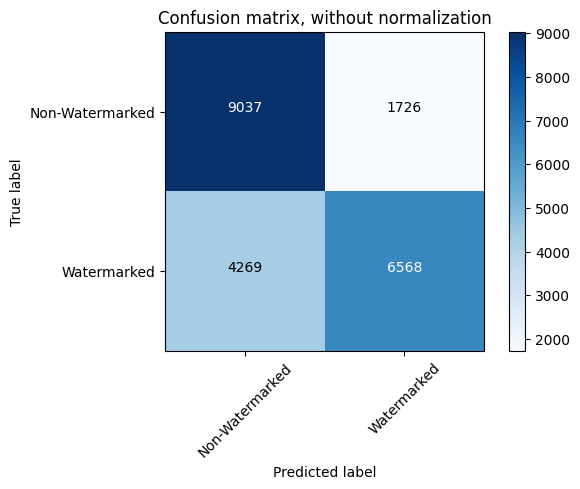

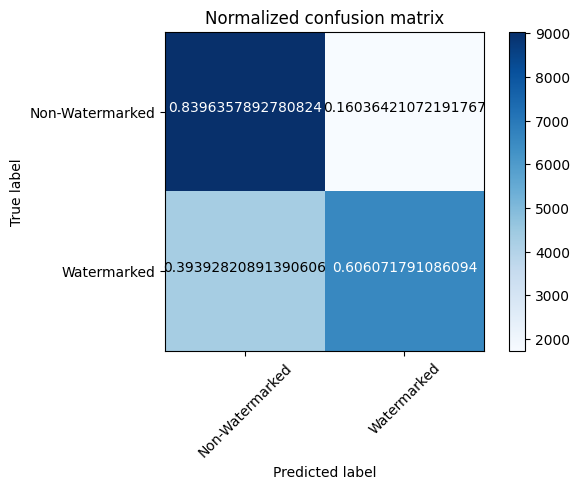

In [ ]:
# Assuming you have 'test_loader' ready and the model is trained and moved to the correct device
model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for images, _, watermark_labels in tqdm(train_loader):
        images = images.to(device)
        watermark_labels = watermark_labels.to(device)  # Ensure labels are long integers
        watermark_labels = watermark_labels.long()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(watermark_labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
auc = roc_auc_score(all_labels, all_preds)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC Score:", auc)

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(all_labels, all_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Watermarked', 'Watermarked'],
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Watermarked', 'Watermarked'], normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
def save_dataset_images(dataset, root_dir):
    labels = ['Forest', 'HerbaceousVegetation', 'AnnualCrop', 'Industrial', 'PermanentCrop', 'SeaLake', 'Residential', 'River', 'Pasture', 'Highway']

    # Ensure directory structure
    for label in labels:
        os.makedirs(os.path.join(root_dir, label, "watermarked"), exist_ok=True)
        os.makedirs(os.path.join(root_dir, label, "non_watermarked"), exist_ok=True)

    pbar = tqdm(enumerate(dataset), total=len(dataset), desc="Saving images")

    for i, (image_tensor, landscape_label, watermark_label) in pbar:
        label_name = labels[landscape_label]
        subfolder = "watermarked" if watermark_label else "non_watermarked"
        jpeg_path = os.path.join(root_dir, label_name, subfolder, f"{i}.jpeg")

        # Convert the PyTorch tensor to a NumPy array
        image_np = image_tensor.numpy()

        # Normalize and save the image as JPEG
        rgb_image = np.transpose(image_np, (1, 2, 0))  # Change to HxWxC
        rgb_image = (rgb_image * 255).astype(np.uint8)
        im = Image.fromarray(rgb_image)
        im.save(jpeg_path)

root_dir = "/content/eurosat/2750"  # Make sure this is correctly set
save_dataset_images(train_dataset, root_dir)

Saving images: 100%|██████████| 21600/21600 [00:11<00:00, 1887.60it/s]


## Maniulating Images

In [ ]:
class Watermarked_Dataset(Dataset):
    def __init__(self, root_dir, categories, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.files = []
        self.labels = []

        for category in categories:
          # Paths to watermarked and non_watermarked subdirectories within each category
          watermarked_dir = os.path.join(root_dir, category, 'watermarked')
          non_watermarked_dir = os.path.join(root_dir, category, 'non_watermarked')

          # Check for watermarked directory and add images
          if os.path.exists(watermarked_dir):
              for file in os.listdir(watermarked_dir):
                  if file.endswith('.jpeg'):
                      file_path = os.path.join(watermarked_dir, file)
                      self.files.append(file_path)
                      self.labels.append(1)  # 1 for watermarked

          # Check for non_watermarked directory and add images
          if os.path.exists(non_watermarked_dir):
              for file in os.listdir(non_watermarked_dir):
                  if file.endswith('.jpeg'):
                      file_path = os.path.join(non_watermarked_dir, file)
                      self.files.append(file_path)
                      self.labels.append(0)  # 0 for non_watermarked

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]

        # Load image with PIL
        image = Image.open(img_path)

        # Convert the image to a PyTorch tensor
        image = transforms.ToTensor()(image)

        # Normalize the image if a transform is provided
        if self.transform:
            image = self.transform(image)  # Apply the transform

        return image, label

# Define the normalization transform
transform = transforms.Compose([
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

category_names = ['AnnualCrop', 'HerbaceousVegetation', 'Forest', 'Pasture', 'Industrial',
                  'SeaLake', 'PermanentCrop', 'Residential', 'River', 'Highway']

In [ ]:
root_dir = '/content/eurosat/2750/'
watermarked_dataset = Watermarked_Dataset(root_dir, category_names, transform=transform)
train_loader = DataLoader(watermarked_dataset, batch_size=32, shuffle=True)


In [ ]:
print(f'Total images: {len(watermarked_dataset)}')
print(f'Total images: {len(train_loader)}')

Total images: 21600
Total images: 675


In [ ]:
# Get the first image and label from the dataset
image, label = watermarked_dataset[0]

# Print the shape; it should be in (C, H, W) format if you've already transposed it
print(image.shape)
# Check what the dataset returns directly
sample_image, sample_label = watermarked_dataset[0]
print(sample_image.shape)  # This should print (3, 64, 64) or similar
# Check the first batch from the DataLoader
for images, labels in train_loader:
    print(images.shape)
    print(type(images))  # Ensure this is a tensor
    break


torch.Size([3, 64, 64])
torch.Size([3, 64, 64])
torch.Size([32, 3, 64, 64])
<class 'torch.Tensor'>


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 16

In [ ]:
image_shape = (3, 64, 64)
image_dim = int(np.prod(image_shape))
latent_dim = 100

In [ ]:
num_class = len(train_loader.dataset.labels)
print('Training samples: ', len(train_loader)*batch_size)
print('number of batches: ', len(train_loader))

Training samples:  10800
number of batches:  675


In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

In [ ]:
def show_images(images):
    fig, ax = plt.subplots(figsize=(20, 20))
    if images.max() > 1.0 or images.min() < 0.0:
            images = (images - images.min()) / (images.max() - images.min())
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach(), nrow=22).permute(1, 2, 0))

def show_batch(dl):
    for images, _ in dl:
        show_images(images)
        break

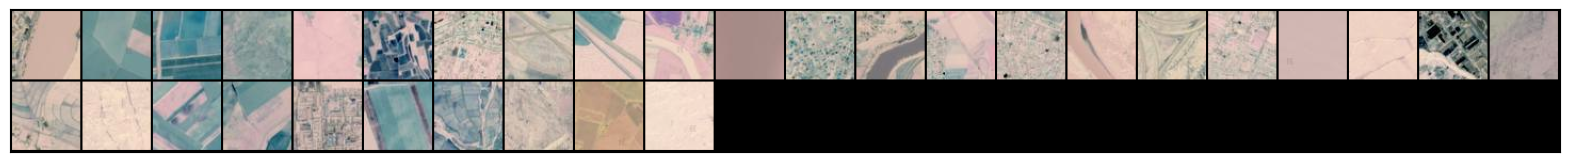

In [ ]:
show_batch(train_loader)

In [ ]:
# Generator Model Class Definition
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Block 1:input is Z, going into a convolution
            nn.ConvTranspose2d(latent_dim, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # Block 2: input is (64 * 8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # Block 3: input is (64 * 4) x 8 x 8
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # Block 4: input is (64 * 2) x 16 x 16
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # Block 5: input is (64) x 32 x 32
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output: output is (3) x 64 x 64
            )
    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
# Discriminator Model Class Definition
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Block 1: input is (3) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 2: input is (64) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 3: input is (64*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 4: input is (64*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Block 5: input is (64*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
            # Output: 1
            )
    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
generator = Generator().to(device)
generator.apply(weights_init_normal)
print(generator)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init_normal)
print(discriminator)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
    (13): Flatten(start_dim=1, end_d

In [ ]:
summary(generator, (100,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

In [ ]:
summary(discriminator, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
         LeakyReLU-2           [-1, 64, 32, 32]               0
            Conv2d-3          [-1, 128, 16, 16]         131,072
       BatchNorm2d-4          [-1, 128, 16, 16]             256
         LeakyReLU-5          [-1, 128, 16, 16]               0
            Conv2d-6            [-1, 256, 8, 8]         524,288
       BatchNorm2d-7            [-1, 256, 8, 8]             512
         LeakyReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 512, 4, 4]       2,097,152
      BatchNorm2d-10            [-1, 512, 4, 4]           1,024
        LeakyReLU-11            [-1, 512, 4, 4]               0
           Conv2d-12              [-1, 1, 1, 1]           8,192
          Sigmoid-13              [-1, 1, 1, 1]               0
          Flatten-14                   

In [ ]:
adversarial_loss = nn.BCELoss()

In [ ]:
def generator_loss(fake_output, label):
    gen_loss = adversarial_loss(fake_output, label)
    #print(gen_loss)
    return gen_loss

In [ ]:
def discriminator_loss(output, label):
    disc_loss = adversarial_loss(output, label)
    return disc_loss

In [ ]:
fixed_noise = torch.randn(128, latent_dim, 1, 1, device=device)
real_label = 1
fake_label = 0

In [ ]:
learning_rate = 0.0002
G_optimizer = optim.Adam(generator.parameters(), lr = learning_rate, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate, betas=(0.5, 0.999))

In [ ]:
num_epochs = 300
D_loss_plot, G_loss_plot = [], []

for epoch in range(1, num_epochs+1):
    D_loss_list, G_loss_list = [], []

    # Adjust enumeration to unpack all items from the loader
    for index, (real_images, _) in enumerate(train_loader):
        D_optimizer.zero_grad()
        real_images = real_images.to(device)

        # Prepare targets for the discriminator
        real_target = Variable(torch.ones(real_images.size(0), 1).to(device))  # Real images
        fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))  # Fake images

        # Discriminator loss on real images
        D_real_loss = discriminator_loss(discriminator(real_images), real_target)
        D_real_loss.backward()

        # Generate fake images
        noise_vector = torch.randn(real_images.size(0), latent_dim, 1, 1, device=device)
        generated_image = generator(noise_vector)

        # Discriminator loss on fake images
        output = discriminator(generated_image.detach())
        D_fake_loss = discriminator_loss(output, fake_target)
        D_fake_loss.backward()

        D_total_loss = D_real_loss + D_fake_loss
        D_loss_list.append(D_total_loss.item())

        D_optimizer.step()

        # Generator training
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator(generated_image), real_target)
        G_loss.backward()
        G_optimizer.step()
        G_loss_list.append(G_loss.item())

    # Logging
    print(f'Epoch: [{epoch}/{num_epochs}]: D_loss: {np.mean(D_loss_list):.3f}, G_loss: {np.mean(G_loss_list):.3f}')
    D_loss_plot.append(np.mean(D_loss_list))
    G_loss_plot.append(np.mean(G_loss_list))

    # Saving generated images and model at the last epoch
    if epoch == 300:
        for i in range(generated_image.shape[0]):
            save_image(generated_image[i], f'/content/eurosat/2750/generated/{i}.png', normalize=True)
        torch.save(generator.state_dict(), f'/content/eurosat/2750/generator_epoch_{epoch}.pth')
        torch.save(discriminator.state_dict(), f'/content/eurosat/2750/discriminator_epoch_{epoch}.pth')

Epoch: [1/3]: D_loss: 0.565, G_loss: 5.981
Epoch: [2/3]: D_loss: 0.468, G_loss: 4.662
Epoch: [3/3]: D_loss: 0.663, G_loss: 4.028


In [ ]:
def zip_all_png(directory_path, zip_file_path):
    # Create a ZipFile object in write mode
    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        # Walk through the directory
        for foldername, subfolders, filenames in os.walk(directory_path):
            for filename in filenames:
                # Check if the file is a PNG
                if filename.endswith('.png'):
                    # Create the complete filepath of the file in directory
                    file_path = os.path.join(foldername, filename)
                    # Add file to the zip file
                    zipf.write(file_path, arcname=filename)

# Usage
directory_to_zip = '/content/eurosat/2750/generated'
zip_output_path = '/content/generated_images.zip'
zip_all_png(directory_to_zip, zip_output_path)

In [ ]:
def zip_all_files(directory_path, zip_file_path):
    # Create a ZipFile object in write mode
    with zipfile.ZipFile(zip_file_path, 'w') as zipf:
        # Walk through the directory
        for foldername, subfolders, filenames in os.walk(directory_path):
            for filename in filenames:
                # Create the complete filepath of the file in directory
                file_path = os.path.join(foldername, filename)
                # Define the archive name to be the path relative to the directory being zipped
                arcname = os.path.relpath(file_path, directory_path)
                # Add file to the zip file
                zipf.write(file_path, arcname=arcname)

# Usage
directory_to_zip = '/content/eurosat/2750'
zip_output_path = '/content/fulldataset.zip'
zip_all_files(directory_to_zip, zip_output_path)